# OCI BigData Benchmark

The purpose of this document is to provide performance measures of bigdata workloads on the oracle cloud infrastructure.

The following sections are addressed:

- standalone and cluster mode (3+ BM.DenseIO2.52) using AD-Spanning
- NVMe and block storage comparison
- Storage performance by block volume size (varied IOPS/Throughput)
- CPU/IO intensive workload performance indicator
- Additional workloads e.g. ml


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Updated performance results, now THREE datanodes over standalone

The question was raised during the call to run the benchmark using a Hadoop cluster and see better results hopefully.
AD-Spanning† provides terraform to automate infrastructure provisioning by easily modifying variables, therefore, I was able to setup a Hadoop cluster with 3 worker nodes by selecting BM.DenseIO2.52 and other server types in these experiments. Java execution parameters are also updated to avoid misconfiguration. For example, a number of mappers are set similar to a total number of virtual cores. BM.DenseIO2.52 provides 104 virtual cores and thus three datanodes provide 312 total. The number of mappers and reducers were configured between 52 and 204 per node based on server types. The number shouldn't be too small or large like 1 and 1000 to consume most resources available properly. BM.DenseIO2.52 consists of two Intel (Skylake) Xeon Platinum 8167M processors, 26 cores per Socket @ 2.0 GHz, 786 GB DDR4 Memory, 2 x 25 G Ethernet and 51.2TB (8 x 6.4TB) local NVMe storage.

† https://github.com/cloud-partners/oci-cloudera/blob/master/AD-Spanning/

## Caveat

* Systems
 - 3 worker nodes by BM.DenseIO2.52 (or BM.Standard2.52)
 - 2 master nodes by VM.Standard2.24
 - 1 Utility node by vm.Standard2.8
 - 1 Bastion node by VM.Standard2.8

* Experiment
 - 1 iteration


## Validation

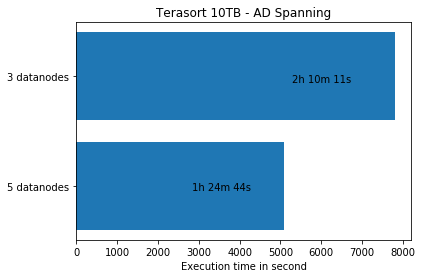

In [97]:
val = (5084, 7811)
pos = arange(2)+.5

plt.barh(pos,val, align='center')
plt.yticks(pos, ('5 datanodes', '3 datanodes'))
plt.text(0.5,0.25, "1h 24m 44s", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.8,0.75, "2h 10m 11s", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel('Execution time in second')
plt.title('Terasort 10TB - AD Spanning')

plt.show()

Terasort outputs can be found here: https://github.com/lee212/benchmark-baremetal/blob/dev/results/bm.denseio2.52.noblock.3workers/TSORT_SUMMARY.10tb.txt

### Hadoop workloads

This is a simple comparison over the early results by a single machine and new data from 3 datanodes. The execution time for each workload was reduced by up to four times compared to the previous results. The "large" data size used here was still relatively small but the results indicated that 3 nodes distributed Hadoop jobs properly. I also ran another set of tests with "bigdata" data size in the section below.

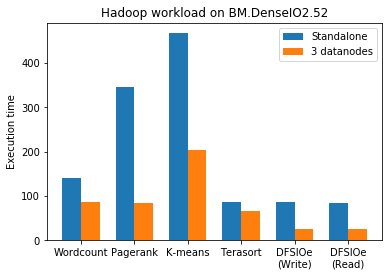

In [50]:
# "large" data size in byte:
# - wordcount: 3284920055
# - pagerank: 259928115
# - kmeans: 4016371699
# - terasort: 3200000000
# - DFSIOe: 678720232

# note that dfsioe is a measurement of write
standalone = (139.603, 345.369, 467.136, 85.554, 85.519, 84.150)
threenodes = (86.679, 83.355, 203.044, 66.7744, 25.393, 24.624)

ind = np.arange(len(threenodes))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, standalone, width, label='Standalone')
rects2 = ax.bar(ind + width/2, threenodes, width, label='3 datanodes')

ax.set_ylabel('Execution time')
ax.set_title('Hadoop workload on BM.DenseIO2.52')
ax.set_xticks(ind)
ax.set_xticklabels(('Wordcount', 'Pagerank', 'K-means', 'Terasort', 'DFSIOe\n(Write)', "DFSIOe\n(Read)"))
ax.legend()
plt.show()


* HiBench "large" data size was used where the size in byte is:
 - wordcount: 3284920055
 - pagerank: 259928115
 - kmeans: 4016371699
 - terasort: 3200000000
 - DFSIOe: 678720232
* Logs can be found at (*large.time.txt files): https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.denseio2.52.noblock.3workers


## TestDFSIO

TestDFSIO benchmark is to evaluate the performance of HDFS. I ran TestDFSIO (read/write) to compare distributed I/O performance between local NVMe SSDs and block storages. Note that using OCI block storages does not mean that magnetic disk drive is attached as a storage media according to this† but the performance is limited to the network bandwidth, i.e. 2x25GbE at the BM second generation. This experiment was performed on three data nodes with BM.DenseIO2.52 utilizing eight local NVMe devices and with BM.Standard2.52 mounting three 500GB volume block storages. The goal is to observe storage performance between local NVMe and block storage where up to 5.5M IOPS and .4M IOPS were measured respectively according to this‡.
  
† https://blogs.oracle.com/cloud-infrastructure/announcing-block-volume-service-enhancements  
‡ https://blogs.oracle.com/cloud-infrastructure/high-performance-x7-compute-service-review-analysis

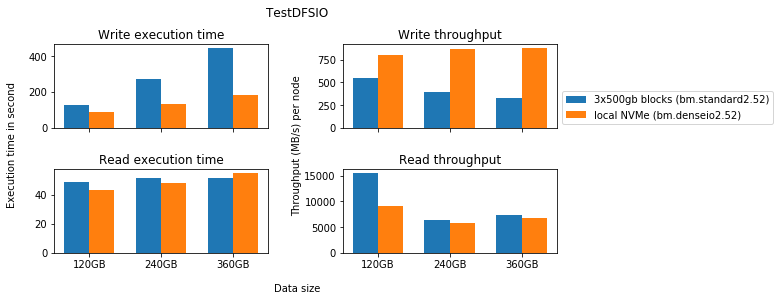

In [55]:
# 120/240/360GB data size divided by 225 files 
bmdense2_52_3nodes_225maps_write = (90.024, 132.87, 180.424)
bmdense2_52_3nodes_225maps_read = (43.451, 48.016, 54.583)
bmdense2_52_3nodes_225maps_write_throughput = (803.441, 869.878, 880.804)
bmdense2_52_3nodes_225maps_read_throughput = (9148.09, 5815.45, 6731.69)

bmstandard2_52_3x500gb_3nodes_225maps_write = (125.176, 268.947, 444.167)
bmstandard2_52_3x500gb_3nodes_225maps_read = (48.59, 51.697, 51.639)
bmstandard2_52_3x500gb_3nodes_225maps_write_throughput = (547.461, 395.71, 327.186) 
bmstandard2_52_3x500gb_3nodes_225maps_read_throughput = (15454.3, 6454.11, 7427.27)
ind = np.arange(len(bmstandard2_52_3x500gb_3nodes_60maps_write))

fig, axs = plt.subplots(2, 2, figsize=(9, 4),sharex=True, sharey=False)
fig.suptitle("TestDFSIO")
fig.subplots_adjust(top=0.85, hspace=0.5, wspace=0.35)
fig.text(0.5, -0.01, "Data size", ha='center')
fig.text(0.06, 0.5, 'Execution time in second', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.5, 'Throughput (MB/s) per node', ha='center', va='center', rotation='vertical')

width = 0.35
ridx = 0
idx=0
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3x500gb_3nodes_225maps_write, width)
axs[ridx][idx].bar(ind + width/2, bmdense2_52_3nodes_225maps_write, width)
axs[ridx][idx].set_title('Write execution time')

idx=1
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3x500gb_3nodes_225maps_write_throughput, width, label='3x500gb blocks (bm.standard2.52)')
axs[ridx][idx].bar(ind + width/2, bmdense2_52_3nodes_225maps_write_throughput, width, label='local NVMe (bm.denseio2.52)')
axs[ridx][idx].set_title('Write throughput')
axs[ridx][idx].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

ridx = 1
idx = 0
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3x500gb_3nodes_225maps_read, width)
axs[ridx][idx].bar(ind + width/2, bmdense2_52_3nodes_225maps_read, width)
axs[ridx][idx].set_title('Read execution time')

idx=1
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3x500gb_3nodes_225maps_read_throughput, width)
axs[ridx][idx].bar(ind + width/2, bmdense2_52_3nodes_225maps_read_throughput, width)
axs[ridx][idx].set_title('Read throughput')

axs[ridx][idx].set_xticks(ind)
axs[ridx][idx].set_xticklabels(('120GB', '240GB', '360GB'))
plt.show()

* Logs for local NVMe can be found at: https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.denseio2.52.noblock.3workers/dfsio
  * 225 mappers were defined where results are stored in resFile/dfsio.225.* files
* Logs for 3x500gb blocks can be found at: https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.standard2.52.3workers/three_500gb_blocks
  * 225 mappers were defined where results are stored in resFile/dfsio.225.* files
* List of commands executed can be found at: https://github.com/lee212/benchmark-baremetal/blob/dev/results/bm.denseio2.52.noblock.3workers/dfsio/cmd.dfsio.upto360gb.sh

## Block storage performance by volume size

IOPS vary based on allocated volume size, for example, 12,000 IOPS and 96 MB/s throughput are the limits in 200GB, whereas 500GB has 25,000 IOPS and 320 MB/s throughput according to this†. This experiment is to measure TestDFSIO benchmark with different block storage volume sizes.

† https://cloud.oracle.com/storage/block-volume/faq#capacity

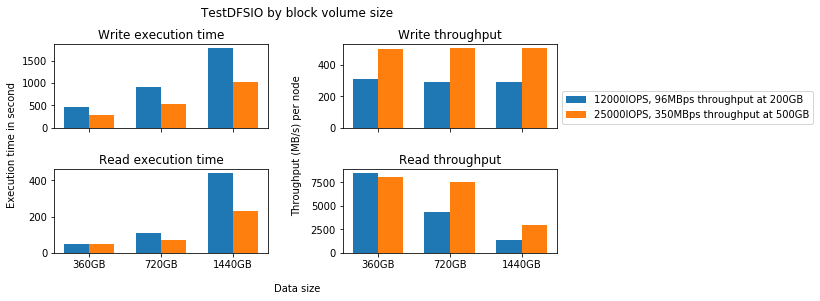

In [41]:
# 360/720/1440GB data size divided by 312 files 
bmstandard2_52_3nodes_12x200gb_write_elapsed = (469.845, 916.27, 1780.872)
bmstandard2_52_3nodes_12x200gb_read_elapsed = (49.204, 111.534, 437.746)
bmstandard2_52_3nodes_12x200gb_write_throughput = (310.368, 288.359, 292.493)
bmstandard2_52_3nodes_12x200gb_read_throughput = (8466.35, 4332.73, 1370.09)

bmstandard2_52_3nodes_12x500gb_write_elapsed = (291.43, 527.158, 1015.979)
bmstandard2_52_3nodes_12x500gb_read_elapsed = (49.194, 71.288, 229.269)
bmstandard2_52_3nodes_12x500gb_write_throughput = (500.116, 504.619, 505.696)
bmstandard2_52_3nodes_12x500gb_read_throughput = (8124.77, 7518.93, 2986.79)

ind = np.arange(len(bmstandard2_52_3nodes_12x500gb_write_elapsed))

fig, axs = plt.subplots(2, 2, figsize=(9, 4),sharex=True, sharey=False)
fig.suptitle("TestDFSIO by block volume size")
fig.subplots_adjust(top=0.85, hspace=0.5, wspace=0.35)
fig.text(0.5, -0.01, "Data size", ha='center')
fig.text(0.06, 0.5, 'Execution time in second', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.5, 'Throughput (MB/s) per node', ha='center', va='center', rotation='vertical')

width = 0.35
ridx = 0
idx=0
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3nodes_12x200gb_write_elapsed, width)
axs[ridx][idx].bar(ind + width/2, bmstandard2_52_3nodes_12x500gb_write_elapsed, width)
axs[ridx][idx].set_title('Write execution time')

idx=1
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3nodes_12x200gb_write_throughput, width, label='12000IOPS, 96MBps throughput at 200GB')
axs[ridx][idx].bar(ind + width/2, bmstandard2_52_3nodes_12x500gb_write_throughput, width, label='25000IOPS, 350MBps throughput at 500GB')
axs[ridx][idx].set_title('Write throughput')
axs[ridx][idx].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

ridx = 1
idx = 0
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3nodes_12x200gb_read_elapsed, width)
axs[ridx][idx].bar(ind + width/2, bmstandard2_52_3nodes_12x500gb_read_elapsed, width)
axs[ridx][idx].set_title('Read execution time')

idx=1
axs[ridx][idx].bar(ind - width/2, bmstandard2_52_3nodes_12x200gb_read_throughput, width)
axs[ridx][idx].bar(ind + width/2, bmstandard2_52_3nodes_12x500gb_read_throughput, width)
axs[ridx][idx].set_title('Read throughput')

axs[ridx][idx].set_xticks(ind)
axs[ridx][idx].set_xticklabels(('360GB', '720GB', '1440GB'))
plt.show()

* Logs for 200GB volumes can be found at: https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.standard2.52.3workers/twelve_200gb_blocks/resFile
  * 312 mappers were defined where results are stored in resFile/dfsio.312.* files
* Logs for 500GB volumes can be found at: https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.standard2.52.3workers/twelve_500gb_blocks
  * 312 mappers were defined where results are stored in resFile/dfsio.312.* files
* List of commands executed can be found at: https://github.com/lee212/benchmark-baremetal/blob/dev/results/bm.standard2.52.3workers/twelve_500gb_blocks/cmd.dfsio.upto1440gb.sh

## Hadoop workloads and Spark MLlib

Running a workload with different data sizes may indicate performance factor of resource elements e.g. CPU bound/disk bound workloads. As previously mentioned, bigger data size was used to evaluate system performance with additional workloads i.e. Spark MLlib.

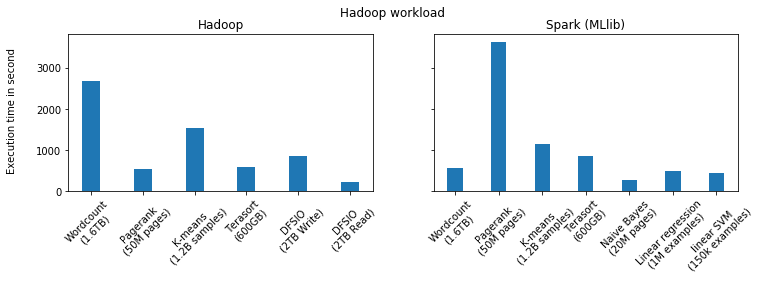

,Hadoop
Wordcount\n(1.6TB),2682.868
Pagerank\n(50M pages),528.771
K-means\n(1.2B samples),1538.520
Terasort\n(600GB),596.079
DFSIO\n(2TB Write),847.038
DFSIO\n(2TB Read),213.692


,Spark
Wordcount\n(1.6TB),563.531675
Pagerank\n(50M pages),3622.991032
K-means\n(1.2B samples),1140.982976
Terasort\n(600GB),846.570264
Naive Bayes\n(20M pages),266.017139
Linear regression\n(1M examples),498.072000
linear SVM\n(150k examples),449.452700


In [100]:
# wordcount, pagerank, kmeans, terasort, dfsio write, dfsio read
hadoop_index = ('Wordcount\n(1.6TB)', 'Pagerank\n(50M pages)', 'K-means\n(1.2B samples)', 'Terasort\n(600GB)', 'DFSIO\n(2TB Write)', "DFSIO\n(2TB Read)")
bigdata_elapsed = (44 * 60 + 42.868, 8 * 60 + 48.771, 25 * 60 + 38.52, 9 * 60 + 56.079, 847.038, 213.692)
# wordcount-spark, pagerank-spark,  kmeans-spark, bayes, linear, svm, 
spark_index = ('Wordcount\n(1.6TB)', 'Pagerank\n(50M pages)', 'K-means\n(1.2B samples)', 'Terasort\n(600GB)', 'Naive Bayes\n(20M pages)', "Linear regression\n(1M examples)", "linear SVM\n(150k examples)")
bigdata_elapsed_spark = (563.531674862, 3622.99103212, 1140.98297596, 846.570264101, 266.017138958, 498.0720, 449.4527)
ind = np.arange(len(bigdata_elapsed))
ind2 = np.arange(len(bigdata_elapsed_spark))

fig, axs = plt.subplots(1, 2, figsize=(12, 3),sharex=False, sharey=True)
fig.suptitle("Hadoop workload")
fig.subplots_adjust(top=0.85, hspace=0.5)
fig.text(0.06, 0.5, 'Execution time in second', ha='center', va='center', rotation='vertical')

width = 0.35
idx=0
axs[idx].bar(ind, bigdata_elapsed, width)
axs[idx].set_title('Hadoop')
axs[idx].set_xticks(ind)
axs[idx].set_xticklabels(hadoop_index, rotation=45)

idx=1
axs[idx].bar(ind2, bigdata_elapsed_spark, width)
axs[idx].set_title('Spark (MLlib)')
axs[idx].set_xticks(ind2)
axs[idx].set_xticklabels(spark_index, rotation=45)
plt.show()

df_hadoop = pd.DataFrame({'Hadoop': bigdata_elapsed}, index=hadoop_index)
df_spark = pd.DataFrame({'Spark': bigdata_elapsed_spark}, index=spark_index)
display(df_hadoop, df_spark)

* Logs for Hadoop can be found at (*bigdata.time.txt files): https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.denseio2.52.noblock.3workers
* Logs for Spark can be found at: https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.denseio2.52.noblock.3workers/spark
* List of Spark commands executed can be found at: https://github.com/lee212/benchmark-baremetal/blob/dev/src/hibench_extra_for_spark/special.cmd

## Hadoop workloads by data size

The wall-clock time of benchmark workloads is related to the size of input data and a system scales linearly as expected. There are bottlenecks and points of contention that prevent it from utilizing compute resources available. I did not describe those issues or identify but tried to show the need for system optimization based on individual use cases and different applications. This experiment was performed for the six workloads that I've tested earlier but with different data size, 'huge', 'gigantic' and 'bigdata' defined by HiBench†. It seems the size of bigdata is still small to run on OCI BM servers which provide 52 OCUs and 768GB memory, but those data sizes might be enough to demonstrate scalability as an example.

† https://github.com/intel-hadoop/HiBench/tree/master/conf/workloads

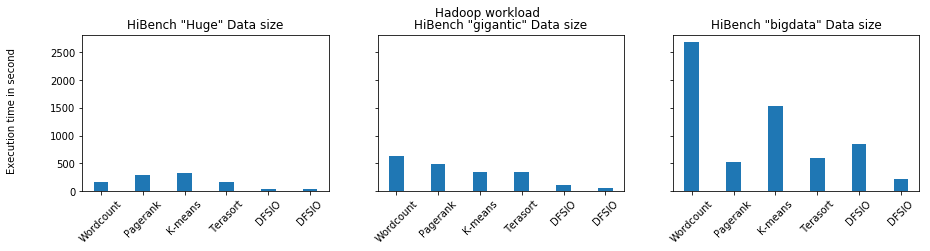

,bigdata,gigantic,huge
Wordcount,2682.868,633.9660,166.609
Pagerank,528.771,483.9222,288.331
K-means,1538.520,341.4340,332.408
Terasort,596.079,341.0890,160.648
DFSIO,847.038,104.7490,44.311
DFSIO,213.692,50.4310,34.000


In [49]:
# wordcount, pagerank, kmeans, terasort, dfsio write, dfsio read
hadoop_index = ('Wordcount', 'Pagerank', 'K-means', 'Terasort', 'DFSIO', "DFSIO")
huge_elapsed = (2*60 + 46.609, 4*60 + 48.331, 332.408, 2*60 + 40.648 , 44.311, 34.0)
gigantic_elapsed = (10*60 + 33.966,8*60 + 3.9222,341.434, 5*60 + 41.089,104.749, 50.431)
bigdata_elapsed = (44 * 60 + 42.868, 8 * 60 + 48.771, 25 * 60 + 38.52, 9 * 60 + 56.079, 847.038, 213.692)
ind = np.arange(len(bigdata_elapsed))

fig, axs = plt.subplots(1, 3, figsize=(15, 3),sharex=True, sharey=True)
fig.suptitle("Hadoop workload")
fig.subplots_adjust(top=0.85, hspace=0.5)
fig.text(0.06, 0.5, 'Execution time in second', ha='center', va='center', rotation='vertical')

width = 0.35
idx=0
axs[idx].bar(ind, huge_elapsed, width)
axs[idx].set_title('HiBench "huge" Data size')
axs[idx].set_xticks(ind)
axs[idx].set_xticklabels(hadoop_index, rotation=45)

idx=1
axs[idx].bar(ind, gigantic_elapsed, width)
axs[idx].set_title('HiBench "gigantic" Data size')
axs[idx].set_xticks(ind)
axs[idx].set_xticklabels(hadoop_index, rotation=45)

idx=2
axs[idx].bar(ind, bigdata_elapsed, width)
axs[idx].set_title('HiBench "bigdata" Data size')
axs[idx].set_xticks(ind)
axs[idx].set_xticklabels(hadoop_index, rotation=45)
plt.show()


df_by_datasize = pd.DataFrame({'huge': huge_elapsed,'gigantic': gigantic_elapsed,'bigdata': bigdata_elapsed}, index=hadoop_index)
display(df_by_datasize)

* Hibench configuration for the data size (including huge, gigantic, and bigdata) can be found at: https://github.com/intel-hadoop/HiBench/tree/master/conf/workloads
* Logs can be found at: https://github.com/lee212/benchmark-baremetal/tree/dev/results/bm.denseio2.52.noblock.3workers
    * huge: *huge.time.txt
    * gigantic: *gigantic.time.txt
    * bigdata: *bigdata.time.txt

# Discussion
- replication level is 3
  - quicker results can be obtained with lower replication i.e. 1
- Operating system tuning for optimal performance
    - e.g. sysctl.conf, vm_dirty_ratio
- 3+ sampling is required
    - these results are collected by a single run
- Additional tests for storage performance e.g. block size or map counts
    - local NVMe seems to provide low latency and low I/O rate standard deviation against Block storage

# Future work

- Comparison with other cloud platforms would be interesting to see e.g. aws i3.metal
- Scalability test with increased node counts would be interesting e.g. 5/10/20 workernodes with a same data size and different sizes e.g. 10TB/20TB/40TB
- Extended Data Tiering test with Hadoop storage policy e.g. LAZY_PERSIST
- ML/AI workloads
   - framework comparison e.g. pytorch, tensorflow, CNTK
   - MLPerf

## Appendix: Reproducible experiments (TODO)

All these experiments are reproducible with the scripts. README should provide simple instructions to replicate.